https://rpubs.com/italogoncalves/tempdata3d

# 1  Import and Setup

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras

from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense, RepeatVector, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping

from matplotlib.cm import ScalarMappable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
!mkdir -p /content/data

In [ ]:
if not os.path.exists('/content/data/global-historical-climatology-network.zip'):
    !curl -L -o /content/data/global-historical-climatology-network.zip https://www.kaggle.com/api/v1/datasets/download/noaa/global-historical-climatology-network

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4642k  100 4642k    0     0  6640k      0 --:--:-- --:--:-- --:--:-- 6640k


In [ ]:
if not os.path.exists('/content/data/ghcn-m-v1.csv'):
  !unzip /content/data/global-historical-climatology-network.zip -d /content/data

Archive:  /content/data/global-historical-climatology-network.zip
  inflating: /content/data/ghcn-m-v1.csv  


# 2  Preprocessing


In [ ]:
# Load the CSV file
rawdata = pd.read_csv('/content/data/ghcn-m-v1.csv')

In [ ]:
# Reshape the data
procdata = rawdata.melt(id_vars=['year', 'month', 'lat'], var_name='lon', value_name='temp')

# Filter out invalid temperatures
procdata = procdata[procdata['temp'] != -9999]

# Process latitude and longitude
procdata['lat_sign'] = np.where(procdata['lat'].str.contains('S'), -1, 1) # South -> -1, North -> 1
procdata['lon_sign'] = np.where(procdata['lon'].str.contains('W'), -1, 1) # West  -> -1, East  -> 1

# Clean lat and lon columns
procdata['lat'] = procdata['lat'].str.replace('[NS]', '', regex=True)
procdata['lon'] = procdata['lon'].str.replace('[EW]', '', regex=True)
procdata['lon'] = procdata['lon'].str.replace('lon_', '', regex=True)

# Split coordinates and calculate midpoint
procdata[['lat1', 'lat2']] = procdata['lat'].str.split('-', expand=True).astype(float)
procdata[['lon1', 'lon2']] = procdata['lon'].str.split('_', expand=True).astype(float)

procdata['lat'] = procdata['lat_sign'] * (procdata['lat1'] + procdata['lat2']) / 2
procdata['lon'] = procdata['lon_sign'] * (procdata['lon1'] + procdata['lon2']) / 2

# Add time column
procdata['time'] = procdata['year'] + (procdata['month'] - 1) / 12

In [ ]:
# Convert 'year' and 'month' columns to datetime objects
procdata['date'] = pd.to_datetime(procdata[['year', 'month']].assign(day=1)) # .dt.to_period('M') # for YYYY-MM format

procdata = procdata[['date', 'lat', 'lon', 'temp']].reset_index(drop=True)

In [ ]:
# Display detailed information
print(procdata.info())

# Check for unique values in 'date', 'lat', 'lon' columns
print(f"{'Unique months:':<20} {procdata['date'].nunique()}")
print(f"{'Unique latitudes:':<20} {procdata['lat'].nunique()}")
print(f"{'Unique longitudes:':<20} {procdata['lon'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863452 entries, 0 to 2863451
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   lat     float64       
 2   lon     float64       
 3   temp    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 87.4 MB
None
Unique months:       1641
Unique latitudes:    38
Unique longitudes:   72


In [ ]:
# procdata.to_csv('procdata.csv', index=False)
procdata

,date,lat,lon,temp
0,1880-01-01,27.5,-177.5,-7
1,1880-01-01,22.5,-177.5,-44
2,1880-01-01,17.5,-177.5,-48
3,1880-01-01,-12.5,-177.5,-15
4,1880-01-01,-17.5,-177.5,44
...,...,...,...,...
2863447,2016-09-01,-37.5,177.5,66
2863448,2016-09-01,-42.5,177.5,23
2863449,2016-09-01,-47.5,177.5,-1
2863450,2016-09-01,-52.5,177.5,-13


# 4  Monthly Temprature Anomalies based on Location


## Getting the location data

In [ ]:
def get_location_data(procdata, target_lat, target_lon):
  """
  Selects data for a specific location (latitude and longitude)
  by finding the closest match in the procdata DataFrame.

  Args:
    procdata: The pandas DataFrame containing the temperature data.
    target_lat: The target latitude.
    target_lon: The target longitude.

  Returns:
    A pandas DataFrame containing the monthly average temperatures for the
    specified location, or None if no matching location is found.
  """

  # Calculate the distance between the target coordinates and all coordinates in the DataFrame
  procdata['distance'] = np.sqrt((procdata['lat'] - target_lat)**2 + (procdata['lon'] - target_lon)**2)

  # Find the index of the row with the minimum distance
  closest_index = procdata['distance'].idxmin()

  # Get the latitude and longitude of the closest match
  closest_lat = procdata.loc[closest_index, 'lat']
  closest_lon = procdata.loc[closest_index, 'lon']

  # Filter the DataFrame to include only data for the closest match
  location_data = procdata[(procdata['lat'] == closest_lat) & (procdata['lon'] == closest_lon)]

  # If no matching location is found, return None
  if location_data.empty:
    print("No matching location found.")
    return None
  else:
    print(f"Closest match found at latitude: {closest_lat}, longitude: {closest_lon}")

    # Extract relevant columns (month, temp)
    location_data = location_data[['date', 'temp']]
    # location_data = location_data.rename(columns={'date': 'month', 'temp': 'monthly_avg'})
    return location_data, (closest_lat, closest_lon)


In [ ]:
def get_loc_data(data, tgt_lat, tgt_lon):
    # Selects data for a specific location by
    # finding the closest match.

    # Calculate distance to target coordinates
    data['dist'] = np.sqrt((data['lat'] - tgt_lat) ** 2
                           + (data['lon'] - tgt_lon) ** 2)

    # Find the closest match
    closest_idx = data['dist'].idxmin()
    closest_lat = data.loc[closest_idx, 'lat']
    closest_lon = data.loc[closest_idx, 'lon']

    # Filter data for the closest match
    loc_data = data[(data['lat'] == closest_lat) &
                    (data['lon'] == closest_lon)]

    if loc_data.empty:
        print("No matching location found.")
        return None
    else:
        print(f"Closest match found at lat: {closest_lat}, lon: {closest_lon}")
        return loc_data[['date', 'temp']], (closest_lat, closest_lon)


## Monthly Temprature Anomalies of Paris

In [ ]:
# Usage for Paris:
loc_coor_paris = (48.8566, 2.3522)          # Latitude and Longitude of Paris
loc_coor_addisababa =(9.02497, 38.74689)    # Latitude and Longitude of Addis Ababa

loc_data_paris, obtained_coordinate = get_location_data(procdata, loc_coor_paris[0], loc_coor_paris[1])

print(loc_data_paris.shape)

Closest match found at latitude: 47.5, longitude: 2.5
(1641, 2)


In [ ]:
loc_data_paris.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 1420304 to 1460878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1641 non-null   datetime64[ns]
 1   temp    1641 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 38.5 KB


In [ ]:
print(f"{'Starting date: ':<15} {loc_data_paris['date'].dt.to_period('M').min()}")
print(f"{'Ending date: ':<15} {loc_data_paris['date'].dt.to_period('M').max()}")

Starting date:  1880-01
Ending date:    2016-09


## Data preparation

In [ ]:
# Define some hyperparameters
data_to_use = loc_data_paris

# Time data bing x and the y the dependent variale
x , y = 'date', 'temp'

train_size = 0.80
seq_size = 12 # 30

print(data_to_use.describe())

                                date         temp
count                           1641  1641.000000
mean   1948-05-01 13:48:22.376599680   -55.851310
min              1880-01-01 00:00:00  -966.000000
25%              1914-03-01 00:00:00  -159.000000
50%              1948-05-01 00:00:00   -54.000000
75%              1982-07-01 00:00:00    47.000000
max              2016-09-01 00:00:00   436.000000
std                              NaN   159.358469


In [ ]:
train, test = train_test_split(data_to_use, train_size=train_size, shuffle=False) # Split without suffling

print(f"{'Train data: ': <15}\n{train.describe()}")
print(f"{'Test size: ': <15}\n{test.describe()}")

Train data:    
                                date         temp
count                           1312  1312.000000
mean   1934-08-16 15:30:43.902439040   -77.233232
min              1880-01-01 00:00:00  -966.000000
25%              1907-04-23 12:00:00  -175.000000
50%              1934-08-16 12:00:00   -74.000000
75%              1961-12-08 18:00:00    25.000000
max              1989-04-01 00:00:00   387.000000
std                              NaN   156.232744
Test size:     
                                date        temp
count                            329  329.000000
mean   2002-12-31 09:59:38.115501568   29.416413
min              1989-05-01 00:00:00 -348.000000
25%              1996-03-01 00:00:00  -75.000000
50%              2003-01-01 00:00:00   28.000000
75%              2009-11-01 00:00:00  128.000000
max              2016-09-01 00:00:00  436.000000
std                              NaN  142.456476


In [ ]:
# Normalize the dataset
scaler = MinMaxScaler() # StandardScaler() # standardize features by removing the mean and scaling to unit variance
scaler = scaler.fit(train[[y]])



> Best practice to fit the scaler on the training data only and then use that fitted scaler to transform both the training and test data to ensures that the test data remains unseen during the training process, which helps to avoid data leakage and provides a more realistic evaluation of the model's performance.



In [ ]:
# Apply the transformation
train[y] = scaler.transform(train[[y]])
test[y] = scaler.transform(test[[y]])

In [ ]:
print(f"{'Train data: ': <15}\n{train.describe()}")
print(f"{'Test size: ': <15}\n{test.describe()}")

Train data:    
                                date         temp
count                           1312  1312.000000
mean   1934-08-16 15:30:43.902439040     0.656886
min              1880-01-01 00:00:00     0.000000
25%              1907-04-23 12:00:00     0.584627
50%              1934-08-16 12:00:00     0.659276
75%              1961-12-08 18:00:00     0.732446
max              1989-04-01 00:00:00     1.000000
std                              NaN     0.115471
Test size:     
                                date        temp
count                            329  329.000000
mean   2002-12-31 09:59:38.115501568    0.735711
min              1989-05-01 00:00:00    0.456763
25%              1996-03-01 00:00:00    0.658537
50%              2003-01-01 00:00:00    0.734664
75%              2009-11-01 00:00:00    0.808574
max              2016-09-01 00:00:00    1.036216
std                              NaN    0.105289


In [ ]:
def to_sequences(x, y, seq_size=1):
    x_values, y_values = [], []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)


trainX, trainY = to_sequences(train[[y]], train[y], seq_size)
testX, testY = to_sequences(test[[y]], test[y], seq_size)

print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")

trainX shape: (1300, 12, 1)
trainY shape: (1300,)
testX shape: (317, 12, 1)
testY shape: (317,)


## Visualization

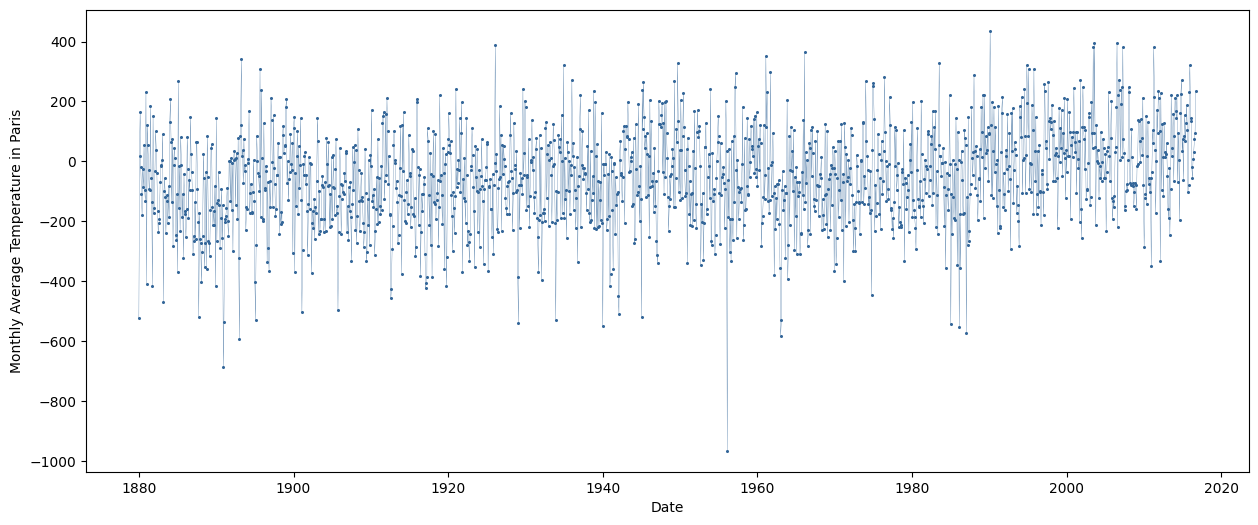

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(loc_data_paris['date'],
         loc_data_paris['temp'],
         color='#336699',  # Line color
         # alpha=0.5,        # Line transparency
         linestyle='-',    # Line style
         linewidth=0.2,
         markersize=1.2,
         marker='o',       # Marker style
         markerfacecolor='#003366',  # Marker fill color
)
plt.xlabel('Date')
plt.ylabel('Monthly Average Temperature in Paris')
#plt.title('Monthly Average Temperature in Paris Over Time')
plt.show()

## Model Definition and Training

In [ ]:
input_shape = (trainX.shape[1], trainX.shape[2])  # Define input shape

In [ ]:
model = Sequential(
    [
        Input(shape=input_shape),               # Input layer
        LSTM(128, return_sequences=False),      # First LSTM layer (encoder)
        Dropout(0.2),                           # Dropout layer
        RepeatVector(trainX.shape[1]),          # RepeatVector layer
        LSTM(128, return_sequences=True),       # Second LSTM layer (decoder)
        Dropout(0.2),                           # Dropout layer
        TimeDistributed(Dense(trainX.shape[2])),    # TimeDistributed Dense layer
    ],
    name="lstm-autoencoder"
)

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "lstm-autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit model with the EarlyStopping callback
history = model.fit(
    trainX, trainY,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],  # Add the callback here
    shuffle=False
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.3088 - val_loss: 0.1131
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1125 - val_loss: 0.0937
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1029 - val_loss: 0.0877
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0990 - val_loss: 0.0881
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0977 - val_loss: 0.0888
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0968 - val_loss: 0.0879


In [ ]:
# Save the best model weights
# model.save_weights(f"/content/{model.name}_weights.weights.h5")

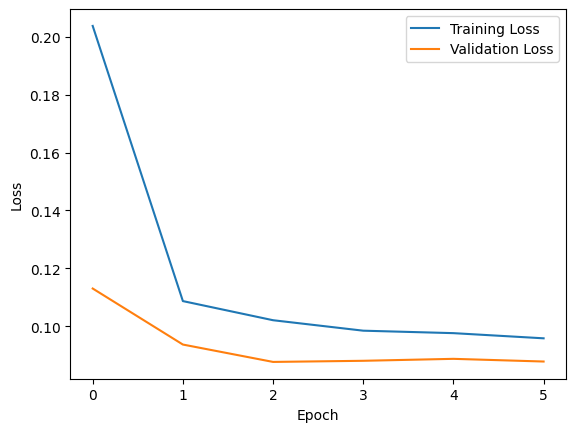

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title(f'Training and Validation Loss for {model.name}') # Add model name as title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction and Analysis

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


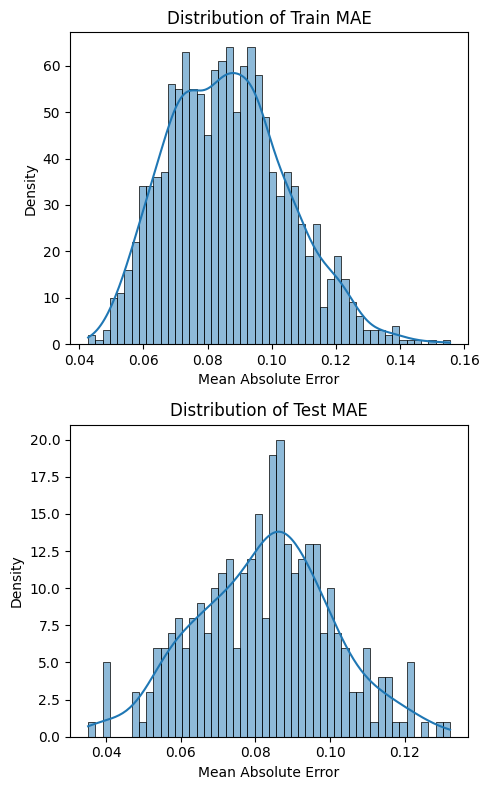

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 8))  # 1 row, 2 columns

# Plot Train MAE distribution on the first subplot
sns.histplot(trainMAE, bins=50, ax=axes[0], kde=True, legend=False)
axes[0].set_xlabel('Mean Absolute Error')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Train MAE')

# Plot Test MAE distribution on the second subplot
sns.histplot(testMAE, bins=50, ax=axes[1], kde=True, legend=False)
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Test MAE')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
max_train_mae = np.max(trainMAE)
print(f"Maximum Train MAE: {max_train_mae}")

THERESHOLD = max_train_mae * 0.80
print(f"Thereshold: {THERESHOLD}")

Maximum Train MAE: 0.15551606405101467
Thereshold: 0.12441285124081175


In [ ]:
# Creat a new dataframe
test_score_df = pd.DataFrame(test[seq_size:], columns=[x])
test_score_df['testMAE'] = testMAE
test_score_df['threshold'] = THERESHOLD
test_score_df['anomaly'] = test_score_df['testMAE'] > test_score_df['threshold']
test_score_df[y] = test[y]

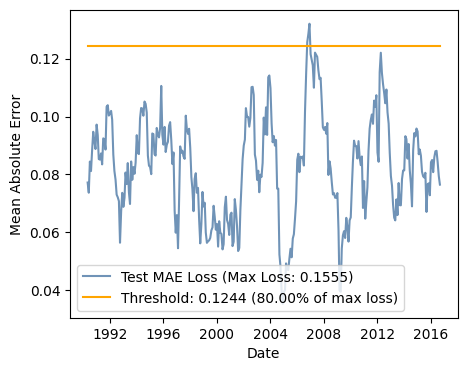

In [ ]:
# Plote testMAE vs. max_trainMAE
plt.figure(figsize=(5, 4))

plt.plot(test_score_df['date'], test_score_df['testMAE'], label=f"Test MAE Loss (Max Loss: {max_train_mae:.4f})", color='#336699', alpha=0.7)
plt.plot(test_score_df['date'], test_score_df['threshold'], label=f"Threshold: {THERESHOLD:.4f} ({THERESHOLD / max_train_mae * 100:.2f}% of max loss)", color='orange')

plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
# plt.title('Test MAE vs Max Train MAE')
plt.legend(loc='lower left')
plt.show()

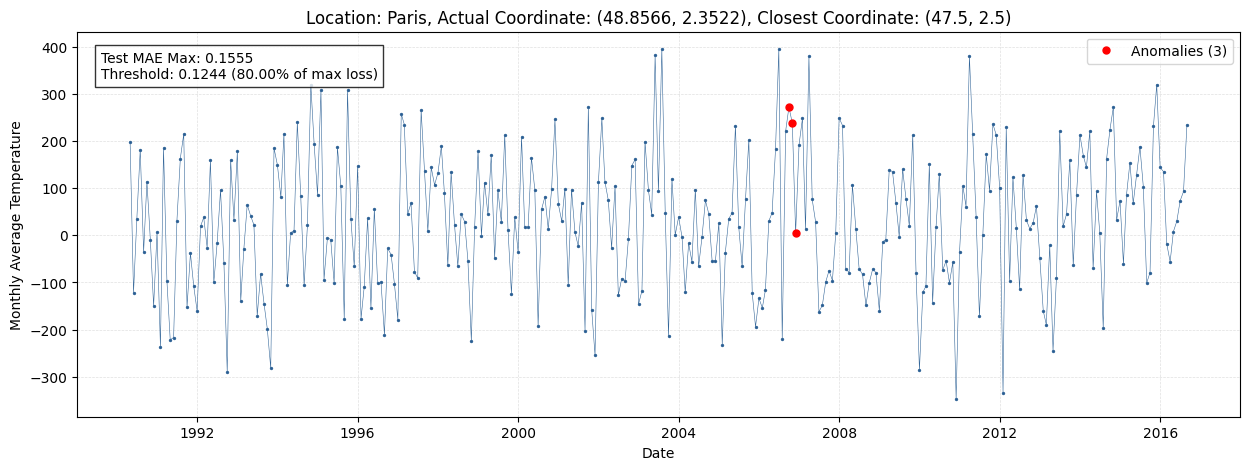

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]

plt.figure(figsize=(15, 5))
plt.plot(test[seq_size:][[x]],
         scaler.inverse_transform(test[seq_size:][[y]]),
         linewidth=0.4,
         color='#336699',
         marker='o',
         markersize=1.4,
         markerfacecolor='#003366',
         alpha=1
         )


plt.plot(anomalies[x],
         scaler.inverse_transform(anomalies[[y]]),
         'ro',
         markersize=5,
         label=f"Anomalies ({len(anomalies)})")
# sns.scatterplot(x=anomalies[x], y=scaler.inverse_transform(anomalies[[y]])[:, 0], color=sns.color_palette()[3], label=f"Anomalies ({len(anomalies)})")
plt.xlabel('Date')
plt.ylabel('Monthly Average Temperature')

title_str = f"Location: Paris, Actual Coordinate: ({loc_coor_paris[0]}, {loc_coor_paris[1]}), Closest Coordinate: {obtained_coordinate}"
plt.title(title_str)

# Add text for test MAE max and threshold
text_str = f"Test MAE Max: {max_train_mae:.4f}\nThreshold: {THERESHOLD:.4f} ({THERESHOLD / max_train_mae * 100:.2f}% of max loss)"
plt.text(0.02, 0.95, text_str, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))  # Adjust position and appearance as needed

plt.legend()
plt.grid(
    color='lightgray',
    linestyle='--',
    linewidth=0.5,
    alpha=0.7
)
plt.show()